# Navigation

---


### Setup

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import torch
%matplotlib inline

**_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

In [2]:
env = UnityEnvironment(file_name="Banana.app", no_graphics=False)
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
env_info = env.reset(train_mode=True)[brain_name]
action_size = brain.vector_action_space_size
state = env_info.vector_observations[0]
state_size = len(state)

### Solution

I used a Dqn agent with duelling architecture and double dqn learning to solve the environment.

The `DuellingQNetwork` in `model.py` uses 2 linear layers of sizes 64, 16 with Relu activation followed by the outputs in the 3rd layer for the action advantage (size=action num) and state value (size=1) functions.

In `dqn_agent.py` I left the default hyperparameters unchanged:

`replay buffer size = 100000
minibatch size = 64
discount factor = 0.99
TAU for soft update of target parameters = 1e-3
learning rate = 5e-4
UPDATE_EVERY = 4`

Epsilon decay was 0.995 from 1.0 to 0.01 during training.

I used gradient norm clipping to 1.

When implementing the dueling architecture in `model.py` the action value is computed from the state value and advantage:
`Q(s,a) = V(s) + A(a,s)`
this wouldn't give a unique solution for V and A, so one needs to substruct the mean of the advantages from the sum to stabilize the solution. This shifts the absolute value of action values, but not their relative strength.

The implementation of double dqn in `dqn_agent.py` requires only a simple modification compared to vanilla dqn: the action for the next state is determined with the local updating network and only the target network is only used for the Q values for this best action.

In [4]:
from dqn_agent import Agent

def train(agent, n_episodes=1000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    solved = False
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f} eps = {:.2f}'.format(i_episode, np.mean(scores_window), eps), end="")
        if i_episode % 50 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f} eps = {:.2f}'.format(i_episode, np.mean(scores_window), eps))
        if not solved and np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            solved = True
            
    torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
    return scores

dqn = Agent(state_size= state_size, action_size= action_size, seed=0, double=False, duel=False)
ddqn = Agent(state_size= state_size, action_size= action_size, seed=0, double=True, duel=True)

### Results

Since the network is small I trained on CPU only. Both dqn and duelling double dqn solved the task similarly around the 400th episode and also evolved similarly until the 1000th episode.

Episode 50	Average Score: 0.40 eps = 0.78
Episode 100	Average Score: 1.12 eps = 0.61
Episode 150	Average Score: 2.91 eps = 0.47
Episode 200	Average Score: 5.34 eps = 0.37
Episode 250	Average Score: 7.27 eps = 0.29
Episode 300	Average Score: 8.32 eps = 0.22
Episode 350	Average Score: 9.95 eps = 0.177
Episode 400	Average Score: 11.23 eps = 0.13
Episode 450	Average Score: 11.97 eps = 0.10
Episode 485	Average Score: 13.09 eps = 0.09
Environment solved in 385 episodes!	Average Score: 13.09
Episode 500	Average Score: 13.16 eps = 0.08
Episode 550	Average Score: 13.72 eps = 0.06
Episode 600	Average Score: 13.96 eps = 0.05
Episode 650	Average Score: 14.27 eps = 0.04
Episode 700	Average Score: 14.91 eps = 0.03
Episode 750	Average Score: 15.36 eps = 0.02
Episode 800	Average Score: 15.84 eps = 0.02
Episode 850	Average Score: 16.55 eps = 0.01
Episode 900	Average Score: 16.56 eps = 0.01
Episode 950	Average Score: 16.65 eps = 0.01
Episode 1000	Average Score: 16.79 eps = 0.01


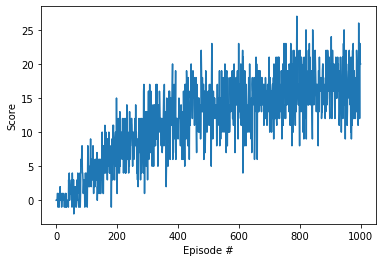

In [5]:
scores = train(dqn)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Episode 50	Average Score: 0.44 eps = 0.78
Episode 100	Average Score: 1.00 eps = 0.61
Episode 150	Average Score: 2.23 eps = 0.47
Episode 200	Average Score: 3.79 eps = 0.37
Episode 250	Average Score: 5.83 eps = 0.29
Episode 300	Average Score: 7.41 eps = 0.22
Episode 350	Average Score: 8.77 eps = 0.17
Episode 400	Average Score: 9.98 eps = 0.13
Episode 450	Average Score: 11.16 eps = 0.10
Episode 500	Average Score: 12.84 eps = 0.08
Episode 504	Average Score: 13.05 eps = 0.08
Environment solved in 404 episodes!	Average Score: 13.05
Episode 550	Average Score: 13.99 eps = 0.06
Episode 600	Average Score: 14.67 eps = 0.05
Episode 650	Average Score: 15.71 eps = 0.04
Episode 700	Average Score: 16.42 eps = 0.03
Episode 750	Average Score: 16.64 eps = 0.02
Episode 800	Average Score: 16.91 eps = 0.02
Episode 850	Average Score: 16.74 eps = 0.01
Episode 900	Average Score: 16.44 eps = 0.01
Episode 950	Average Score: 16.53 eps = 0.01
Episode 1000	Average Score: 16.95 eps = 0.01


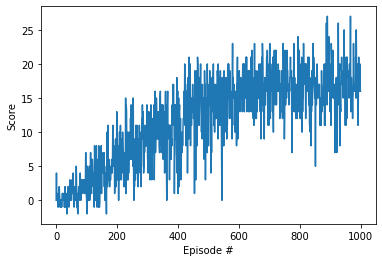

In [6]:
scores = train(ddqn)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Further improvements 

For further experiments I will:
* try different hyperparameters (eg. learning rate, epsilon decay) if learning could be faster and especially if duelling double dqn could learn more efficiently than vanilla dqn
* implement prioritized experience replay which samples experiences that result in larger td error more often